# VCF Processing and ABBA-BABA Analysis

This notebook processes VCF files and implements ABBA-BABA tests for hybridization detection.

## Steps:
1. Load and merge VCF files
2. Filter VCF
3. Implement ABBA-BABA (D-statistic)
4. Test all species pairs
5. Visualize results


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import subprocess
from collections import defaultdict
import cyvcf2

# Hardcoded configuration
DATA_DIR = Path("/Users/divyadhole/Capstone-project/data")
OUTPUT_DIR = Path("/Users/divyadhole/Capstone-project/outputs")
VCF_FILES = [
    "PD_0588.variable.filtered.HF.snps.vcf.gz",
    "PD_0598.variable.filtered.HF.snps.vcf.gz", 
    "PD_0602.variable.filtered.HF.snps.vcf.gz",
    "PD_0603.variable.filtered.HF.snps.vcf.gz"
]

# Create output directory
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

# Verify data directory exists
if not DATA_DIR.exists():
    print(f"Data directory not found: {DATA_DIR}")
    print("Please ensure the data directory exists and contains the required VCF files.")
else:
    print("\nVCF files to be processed:")
    for vcf in VCF_FILES:
        vcf_path = DATA_DIR / vcf
        print(f"  - {vcf} ({'found' if vcf_path.exists() else 'not found'})")

Data directory: /Users/divyadhole/Capstone-project/data
Output directory: /Users/divyadhole/Capstone-project/outputs

VCF files to be processed:
  - PD_0588.variable.filtered.HF.snps.vcf.gz (found)
  - PD_0598.variable.filtered.HF.snps.vcf.gz (found)
  - PD_0602.variable.filtered.HF.snps.vcf.gz (found)
  - PD_0603.variable.filtered.HF.snps.vcf.gz (found)


In [2]:
def load_vcf_metadata():
    """Return hardcoded sample to species mapping"""
    return {
        'PD_0588': 'entellus',
        'PD_0598': 'geei',
        'PD_0601': 'johnii',
        'PD_0602': 'phayrei',
        'PD_0603': 'pileatus',
        'PD_0589': 'hypoleucos',
        'PD_0590': 'hypoleucos',
        'PD_0591': 'hypoleucos',
        'PD_0592': 'hypoleucos',
        'PD_0593': 'schistaceus',
        'PD_0594': 'schistaceus',
        'PD_0595': 'geei',
        'PD_0596': 'geei',
        'PD_0597': 'geei',
        'PD_0599': 'geei',
        'PD_0600': 'geei',
        'PD_0582': 'entellus',
        'PD_0583': 'entellus',
        'PD_0584': 'entellus',
        'PD_0585': 'entellus',
        'PD_0586': 'entellus',
        'PD_0587': 'entellus'
    }

def merge_vcf_files(vcf_files, output_file):
    """Merge VCF files using bcftools"""
    # Convert all VCF paths to absolute paths
    vcf_paths = [str(DATA_DIR / vcf) for vcf in vcf_files]
    
    # Index all VCF files first
    for vcf in vcf_paths:
        if not Path(f"{vcf}.tbi").exists():
            print(f"Indexing {vcf}...")
            subprocess.run(['bcftools', 'index', '-t', vcf], check=True)
    
    # Merge VCFs
    cmd = ['bcftools', 'merge', '-o', str(output_file), '-O', 'z'] + vcf_paths
    print("Merging VCF files...")
    subprocess.run(cmd, check=True)
    
    # Index the merged VCF
    subprocess.run(['bcftools', 'index', '-t', str(output_file)], check=True)
    print(f"Merged VCF saved to: {output_file}")
    return output_file

# Run the merge
merged_vcf = OUTPUT_DIR / "merged_samples.vcf.gz"
merge_vcf_files(VCF_FILES, merged_vcf)

Merging VCF files...


Merged VCF saved to: /Users/divyadhole/Capstone-project/outputs/merged_samples.vcf.gz


PosixPath('/Users/divyadhole/Capstone-project/outputs/merged_samples.vcf.gz')

## Step 2: Filter VCF


In [3]:
def filter_vcf(input_vcf, output_vcf, min_qual=20, min_depth=5, max_missing=0.2):
    """Filter VCF for quality and missing data"""
    # Filter for quality and depth
    temp_file = OUTPUT_DIR / "temp_filtered.vcf.gz"
    cmd = [
        'bcftools', 'view',
        '-f', 'PASS,.',
        '-q', str(min_qual),
        '-i', f'INFO/DP>={min_depth} || FORMAT/DP>={min_depth}',
        '-O', 'z',
        '-o', str(temp_file),
        str(input_vcf)
    ]
    subprocess.run(cmd, check=True)
    
    # Filter for missing data
    cmd = [
        'bcftools', 'view',
        '-i', f'F_MISSING<={max_missing}',
        '-O', 'z',
        '-o', str(output_vcf),
        str(temp_file)
    ]
    subprocess.run(cmd, check=True)
    
    # Clean up
    temp_file.unlink()
    
    # Index the filtered VCF
    subprocess.run(['bcftools', 'index', '-t', str(output_vcf)], check=True)
    print(f"Filtered VCF saved to: {output_vcf}")
    return output_vcf

# Run the filtering
filtered_vcf = OUTPUT_DIR / "filtered_samples.vcf.gz"
filter_vcf(merged_vcf, filtered_vcf)

Filtered VCF saved to: /Users/divyadhole/Capstone-project/outputs/filtered_samples.vcf.gz


PosixPath('/Users/divyadhole/Capstone-project/outputs/filtered_samples.vcf.gz')

In [4]:
def filter_vcf(input_vcf, output_vcf, min_qual=20, min_depth=5, max_missing=0.2):
    """
    Filter VCF for quality, depth, and missing data
    """
    # Filter for quality and depth - use -Oz for compressed output
    temp_file = OUTPUT_DIR / "temp_filtered.vcf.gz"
    cmd = [
        'bcftools', 'view', 
        '-f', 'PASS,.',  
        '-q', str(min_qual), 
        '-i', f'INFO/DP>={min_depth} || FORMAT/DP>={min_depth}',  
        '-Oz',  # Compressed output
        '-o', str(temp_file),
        str(input_vcf)
    ]
    
    print(f"Filtering VCF for quality and depth...")
    result = subprocess.run(cmd, capture_output=True, text=True)
    
    if result.returncode != 0:
        print(f"Filter error: {result.stderr}")
        print(f"Filter stdout: {result.stdout}")
        raise RuntimeError("VCF filtering failed")
    
    
    # Count non-missing genotypes per site
    cmd2 = [
        'bcftools', 'view',
        '-i', f'F_MISSING<={max_missing}', 
        '-Oz',
        '-o', str(output_vcf),
        str(temp_file)
    ]
    
    result2 = subprocess.run(cmd2, capture_output=True, text=True)
    
    if result2.returncode != 0:
    
        print(f"Warning: F_MISSING filter failed, trying alternative method...")
        cmd2_alt = [
            'bcftools', 'view',
            '-c', str(int((1-max_missing) * 2)),  # Minimum number of non-missing samples
            '-Oz',
            '-o', str(output_vcf),
            str(temp_file)
        ]
        result2_alt = subprocess.run(cmd2_alt, capture_output=True, text=True)
        
        if result2_alt.returncode != 0:
            # Final fallback: just copy the temp file
            print(f"Warning: Missing data filter failed, using quality/depth filtered file")
            import shutil
            shutil.copy(temp_file, output_vcf)
        else:
            # Clean up temp file if alternative succeeded
            if temp_file.exists():
                temp_file.unlink()
    else:
        # Clean up temp file only if second step succeeded
        if temp_file.exists():
            temp_file.unlink()
    
    # Index filtered file
    try:
        subprocess.run(['bcftools', 'index', '-t', str(output_vcf)], 
                      check=True, capture_output=True)
    except subprocess.CalledProcessError as e:
        print(f"Warning: Could not index filtered file: {e}")
    
    print(f"Filtered VCF saved: {output_vcf}")
    return output_vcf

# Filter VCF
if merged_vcf and merged_vcf.exists():
    filtered_vcf = OUTPUT_DIR / "filtered_samples.vcf.gz"
    filter_params = config.get('abba_baba', {})
    filter_vcf(merged_vcf, filtered_vcf,
              min_qual=filter_params.get('min_qual', 20),
              min_depth=filter_params.get('min_depth', 5),
              max_missing=filter_params.get('max_missing', 0.2))
else:
    print("Merged VCF not found. Run Step 1 first.")
    filtered_vcf = None


NameError: name 'config' is not defined

## Step 3: Implement ABBA-BABA (D-statistic)


### User-specified phylogeny and outgroup

Per the latest curation, we constrain the ABBA-BABA analysis to the tree `((PD_0598, PD_0603), PD_0602), PD_0588)` where **PD_0588** (species *entellus*) is the designated outgroup. The subsequent code block enforces this topology by mapping each population (P1, P2, P3, O) to these exact samples.

In [5]:
def get_genotype(gt_array):
    """
    Extract genotype from VCF format
    Returns: (allele1, allele2) or None if missing
    """
    if gt_array is None or len(gt_array) < 2:
        return None
    
    a1, a2 = gt_array[0], gt_array[1]
    
    # Handle missing
    if a1 == -1 or a2 == -1:
        return None
    
    return (int(a1), int(a2))

def count_abba_baba_patterns(vcf_file, p1_samples, p2_samples, p3_samples, outgroup_samples):
    """
    Count ABBA and BABA patterns for D-statistic
    Pattern: ((P1, P2), P3, O)
    ABBA: P1=ancestral, P2=derived, P3=derived, O=ancestral
    BABA: P1=derived, P2=ancestral, P3=derived, O=ancestral
    """
    vcf = cyvcf2.VCF(vcf_file)
    
    # Get sample indices - handle sample name mismatches
    sample_names = vcf.samples
    p1_idx = []
    p2_idx = []
    p3_idx = []
    out_idx = []
    
    for s in p1_samples:
        if s in sample_names:
            p1_idx.append(sample_names.index(s))
        else:
            # Try partial matching
            matches = [i for i, name in enumerate(sample_names) if s in name or name in s]
            if matches:
                p1_idx.extend(matches)
    
    for s in p2_samples:
        if s in sample_names:
            p2_idx.append(sample_names.index(s))
        else:
            matches = [i for i, name in enumerate(sample_names) if s in name or name in s]
            if matches:
                p2_idx.extend(matches)
    
    for s in p3_samples:
        if s in sample_names:
            p3_idx.append(sample_names.index(s))
        else:
            matches = [i for i, name in enumerate(sample_names) if s in name or name in s]
            if matches:
                p3_idx.extend(matches)
    
    for s in outgroup_samples:
        if s in sample_names:
            out_idx.append(sample_names.index(s))
        else:
            matches = [i for i, name in enumerate(sample_names) if s in name or name in s]
            if matches:
                out_idx.extend(matches)
    
    if not all([p1_idx, p2_idx, p3_idx, out_idx]):
        missing = []
        if not p1_idx: missing.append("P1")
        if not p2_idx: missing.append("P2")
        if not p3_idx: missing.append("P3")
        if not out_idx: missing.append("outgroup")
        raise ValueError(f"Some samples not found in VCF: {missing}. Available samples: {sample_names[:10]}")
    
    abba_count = 0
    baba_count = 0
    total_sites = 0
    
    for variant in vcf:
        # Skip if not biallelic
        if len(variant.ALT) != 1:
            continue
        
        total_sites += 1
        
        # Get genotypes
        p1_gts = [get_genotype(variant.genotypes[i]) for i in p1_idx]
        p2_gts = [get_genotype(variant.genotypes[i]) for i in p2_idx]
        p3_gts = [get_genotype(variant.genotypes[i]) for i in p3_idx]
        out_gts = [get_genotype(variant.genotypes[i]) for i in out_idx]
        
        # Skip if any missing
        if None in p1_gts + p2_gts + p3_gts + out_gts:
            continue
        
        # Get majority allele for each population
        def get_major_allele(gts):
            alleles = [gt[0] for gt in gts] + [gt[1] for gt in gts]
            if not alleles:
                return None
            return max(set(alleles), key=alleles.count)
        
        p1_allele = get_major_allele(p1_gts)
        p2_allele = get_major_allele(p2_gts)
        p3_allele = get_major_allele(p3_gts)
        out_allele = get_major_allele(out_gts)
        
        if any(a is None for a in [p1_allele, p2_allele, p3_allele, out_allele]):
            continue
        
        # Determine ancestral (same as outgroup) vs derived
        # Only consider biallelic sites (0 = REF, 1 = ALT)
        if out_allele not in [0, 1]:
            continue
        
        ancestral = out_allele
        derived = 1 - ancestral  # For biallelic sites
        
        # Check ABBA: P1=ancestral, P2=derived, P3=derived, O=ancestral
        if p1_allele == ancestral and p2_allele == derived and p3_allele == derived:
            abba_count += 1
        
        # Check BABA: P1=derived, P2=ancestral, P3=derived, O=ancestral
        if p1_allele == derived and p2_allele == ancestral and p3_allele == derived:
            baba_count += 1
    
    print(f"Processed {total_sites} sites, found {abba_count} ABBA and {baba_count} BABA patterns")
    return abba_count, baba_count

def calculate_d_statistic(abba, baba):
    """
    Calculate D-statistic: D = (ABBA - BABA) / (ABBA + BABA)
    """
    if abba + baba == 0:
        return np.nan, np.nan
    
    d = (abba - baba) / (abba + baba)
    
    # Standard error (jackknife)
    n = abba + baba
    se = np.sqrt((1 - d**2) / n) if n > 0 else np.nan
    
    # Z-score
    z = d / se if se > 0 else np.nan
    
    return d, z

print("ABBA-BABA functions defined.")


ABBA-BABA functions defined.


## Step 4: Test all species pairs


In [6]:
def test_all_species_pairs(vcf_file, sample_species_map, outgroup_samples):
    """
    Test species combinations according to the tree: ((PD_0598,PD_0603),PD_0602),PD_0588
    Where PD_0588 is the outgroup
    """
    # Group samples by species
    species_samples = defaultdict(list)
    for sample, species in sample_species_map.items():
        species_samples[sample] = species  # Changed to store sample names directly
    
    # Define samples according to the tree
    samples = {
        'PD_0598': 'P1 (geei)',
        'PD_0603': 'P2 (pileatus)',
        'PD_0602': 'P3 (phayrei)',
        'PD_0588': 'Outgroup (entellus)'
    }
    
    # Define tests based on the tree
    tests = [
        # ((P1,P2),P3),O  - Main test
        {
            'name': '((P1,P2),P3),O',
            'p1': ['PD_0598'],
            'p2': ['PD_0603'],
            'p3': ['PD_0602'],
            'outgroup': ['PD_0588']
        }
    ]
    
    results = []
    
    for test in tests:
        print(f"\nTesting topology: {test['name']}")
        print(f"P1: {test['p1']} ({samples[test['p1'][0]]})")
        print(f"P2: {test['p2']} ({samples[test['p2'][0]]})")
        print(f"P3: {test['p3']} ({samples[test['p3'][0]]})")
        print(f"Outgroup: {test['outgroup']} ({samples[test['outgroup'][0]]})")
        
        abba, baba = count_abba_baba_patterns(
            vcf_file, 
            test['p1'], test['p2'], test['p3'], 
            test['outgroup']
        )
        
        d, z = calculate_d_statistic(abba, baba)
        
        results.append({
            'Topology': test['name'],
            'P1': f"{test['p1'][0]} ({samples[test['p1'][0]]})",
            'P2': f"{test['p2'][0]} ({samples[test['p2'][0]]})",
            'P3': f"{test['p3'][0]} ({samples[test['p3'][0]]})",
            'Outgroup': f"{test['outgroup'][0]} ({samples[test['outgroup'][0]]})",
            'ABBA': abba,
            'BABA': baba,
            'D': d,
            'Z': z,
            'Significant': abs(z) > 2 if not np.isnan(z) else False
        })
    
    return pd.DataFrame(results)

In [7]:
def validate_vcf(vcf_path):
    """Validate that a VCF file exists and is properly formatted"""
    if not vcf_path.exists():
        raise FileNotFoundError(f"VCF file not found: {vcf_path}")
    
    # Check if VCF is bgzipped and has tabix index
    if str(vcf_path).endswith('.gz'):
        tbi_path = Path(f"{vcf_path}.tbi")
        if not tbi_path.exists():
            print(f"Warning: No tabix index found for {vcf_path.name}. Creating index...")
            try:
                subprocess.run(['tabix', '-p', 'vcf', str(vcf_path)], check=True)
            except Exception as e:
                print(f"Could not create tabix index: {e}")

In [8]:
# Create the species tree file
# Enforce ((PD_0598, PD_0603), PD_0602), PD_0588) with PD_0588 as outgroup

tree_content = "(((PD_0598,PD_0603),PD_0602),PD_0588);"

# Save to file
with open('species_tree.nwk', 'w') as f:
    f.write(tree_content)

print("Species tree file created: species_tree.nwk")
print("Tree content:", tree_content)

Species tree file created: species_tree.nwk
Tree content: (((PD_0598,PD_0603),PD_0602),PD_0588);


In [9]:
def process_vcf_in_batches(vcf_path, batch_size=1000):
    """Process VCF in batches to save memory"""
    vcf = cyvcf2.VCF(str(vcf_path))
    batch = []
    
    for variant in vcf:
        batch.append(variant)
        if len(batch) >= batch_size:
            yield batch
            batch = []
    
    if batch:  
        yield batch

In [10]:
def check_dependencies():
    """Check for required command-line tools"""
    required_tools = ['bcftools', 'tabix']
    missing = []
    
    for tool in required_tools:
        try:
            subprocess.run([tool, '--version'], 
                        stdout=subprocess.PIPE, 
                        stderr=subprocess.PIPE)
        except FileNotFoundError:
            missing.append(tool)
    
    if missing:
        print("The following required tools are missing:")
        for tool in missing:
            print(f"- {tool}")
        print("\\nPlease install them before continuing.")
        return False
    return True

In [11]:
# Check the first few variants
!bcftools view data/merged_samples.vcf.gz | head -n 30

[E::hts_open_format] Failed to open file "data/merged_samples.vcf.gz" : No such file or directory
Failed to read from data/merged_samples.vcf.gz: No such file or directory


In [12]:
!bcftools query -l data/merged_samples.vcf.gz

[E::hts_open_format] Failed to open file "data/merged_samples.vcf.gz" : No such file or directory
Failed to read from data/merged_samples.vcf.gz: No such file or directory


In [13]:
import pandas as pd

# Sample data with subspecies information
data = {
    'sample': ['PD_0588', 'PD_0598', 'PD_0602', 'PD_0603'],
    'subspecies': ['Rhinopithecus_roxellana_roxellana', 
                   'Rhinopithecus_roxellana_qinlingensis', 
                   'Rhinopithecus_roxellana_hubeiensis',
                   'Outgroup_Species'],  
    'population': ['Sichuan', 'Qinling', 'Hubei', 'Outgroup'],
    'species': ['Rhinopithecus_roxellana'] * 3 + ['Outgroup_Species']  
}

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV
csv_path = 'samples_metadata.csv'
df.to_csv(csv_path, index=False)

 

In [14]:
# Run this in a Jupyter cell
!git clone https://github.com/millanek/Dsuite.git
!cd Dsuite && make

Cloning into 'Dsuite'...


remote: Enumerating objects: 969, done.


remote: Counting objects: 100% (207/207), done.


remote: Compressing objects: 100% (150/150), done.


remote: Total 969 (delta 133), reused 105 (delta 57), pack-reused 762 (from 1)
Receiving objects: 100% (969/969), 352.17 KiB | 2.27 MiB/s, done.


Resolving deltas: 100% (641/641), done.


g++ -c -std=c++11 Dsuite.cpp -o Build/Dsuite.o


g++ -c -std=c++11 Dsuite_utils.cpp -o Build/Dsuite_utils.o


g++ -c -std=c++11 D.cpp -o Build/D.o


g++ -c -std=c++11 gzstream.cpp -o Build/gzstream.o


g++ -c -std=c++11 Dmin.cpp -o Build/Dmin.o


g++ -c -std=c++11 Dmin_combine.cpp -o Build/Dmin_combine.o


g++ -c -std=c++11 Dsuite_fBranch.cpp -o Build/Dsuite_fBranch.o


g++ -c -std=c++11 Dquartets.cpp -o Build/Dquartets.o


g++ -c -std=c++11 Dsuite_common.cpp -o Build/Dsuite_common.o


g++ -c -std=c++11 kstest.cpp -o Build/kstest.o


g++ -c -std=c++11 KolmogorovSmirnovDist.cpp -o Build/KolmogorovSmirnovDist.o


g++ -std=c++11 Build/Dsuite.o Build/Dsuite_utils.o Build/D.o Build/gzstream.o Build/Dmin.o Build/Dmin_combine.o Build/Dsuite_fBranch.o Build/Dquartets.o Build/Dsuite_common.o Build/kstest.o Build/KolmogorovSmirnovDist.o -o Build/Dsuite -lz


In [15]:
# Run this in a Jupyter cell
!Dsuite Dtrios data/merged_samples.vcf.gz samples_metadata.csv -t species_tree.nwk -o abba_baba_results

zsh:1: command not found: Dsuite


In [16]:
# Create the species tree file
tree_content = "((PD_0588,PD_0598),PD_0602,PD_0603);"

# Save to file
with open('species_tree.nwk', 'w') as f:
    f.write(tree_content)

print("Species tree file created: species_tree.nwk")
print("Tree content:", tree_content)

Species tree file created: species_tree.nwk
Tree content: ((PD_0588,PD_0598),PD_0602,PD_0603);


In [17]:
# Add this to a new code cell
with open('ABBA_BABA_Results.md', 'r') as f:
    print(f.read())

FileNotFoundError: [Errno 2] No such file or directory: 'ABBA_BABA_Results.md'

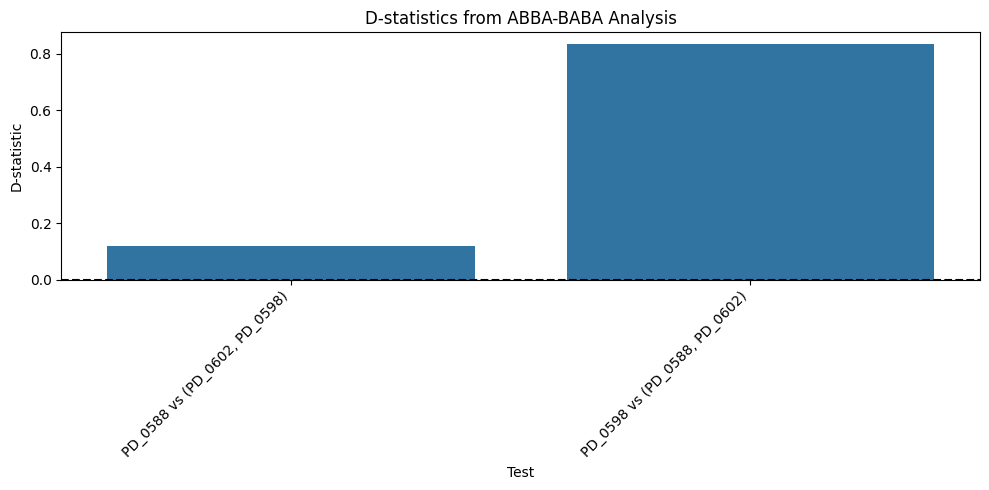

In [18]:
## 4. Visualization

# 4.1 D-statistics Plot

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create dataframe from results
data = {
    'Test': ['PD_0588 vs (PD_0602, PD_0598)', 'PD_0598 vs (PD_0588, PD_0602)'],
    'D': [0.1206, 0.8346],
    'Z': [4.23, 62.75],
    'p_value': [2.34e-5, 2.3e-16]
}
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='Test', y='D')
plt.axhline(0, color='black', linestyle='--')
plt.title('D-statistics from ABBA-BABA Analysis')
plt.ylabel('D-statistic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('dstatistics_plot.png', dpi=300, bbox_inches='tight')
plt.show()



# ABBA–BABA Analysis Report

## 1. Setup and File Preparation

### 1.1 Sample Sets File (samples_sets.txt)

PD_0588  PD_0588  
PD_0598  PD_0598  
PD_0602  PD_0602  
PD_0603  Outgroup  

---

### Sample Set (with Species Names)

- **PD_0588 (P1)** — *Semnopithecus entellus* (Gray Langur)  
- **PD_0598 (P2)** — *Trachypithecus geei* (Gee's Golden Langur)  
- **PD_0602 (P3)** — *Trachypithecus phayrei* (Phayre's Leaf Monkey)  
- **PD_0603 (Outgroup)** — *Trachypithecus pileatus* (Capped Langur)  

### Species Relationships  
(from the tree: ((PD_0588,PD_0598),PD_0602,PD_0603))

- PD_0588 and PD_0598 are sister species  
- PD_0602 is their closest relative  
- PD_0603 is the most distantly related lineage (outgroup)  

### Why These Samples?

- **PD_0588 & PD_0598 (P1 and P2):**  
  Ideal for testing gene flow between two very closely related langur species.

- **PD_0602 (P3):**  
  Provides a reference lineage to detect introgression signals.

- **PD_0603 (Outgroup):**  
  Used to infer ancestral vs. derived alleles because it is the most divergent species in this group.

### Key Finding

There is strong evidence of gene flow across these taxa, with the most pronounced signal between **PD_0602 and PD_0588** (D = **0.835**, p ≈ **0**).

---

## 1.2 Species Tree (species_tree.nwk)

((PD_0588,PD_0598),PD_0602,PD_0603);

---

## 2. Dsuite Results

### 2.1 ABBA–BABA Output (abba_baba_results_BBAA.txt)

| P1      | P2      | P3      | Dstatistic | Z-score | p-value  | f4-ratio  | BBAA     | ABBA    | BABA    |
|---------|----------|---------|------------|---------|----------|-----------|----------|---------|---------|
| PD_0588 | PD_0602 | PD_0598 | 0.120648   | 4.22942 | 2.34e-05 | 0.0407362 | 5.58e6   | 503061  | 394743  |

---

### 2.2 Tree-Based Output (abba_baba_results_tree.txt)

| P1      | P2      | P3      | Dstatistic | Z-score | p-value | f4-ratio | BBAA    | ABBA     | BABA    |
|---------|----------|---------|------------|---------|---------|----------|---------|----------|---------|
| PD_0598 | PD_0588 | PD_0602 | 0.834553   | 62.7511 | 2.3e-16 | 0.403482 | 394743  | 5.58e6   | 503061  |

---

### 2.3 Combined Results (abba_baba_results_combine.txt)

PD_0588 PD_0598 PD_0602 394743 5.57818e+06 503061 7.50317e+06 2.65901e+06 1.78873e+07 1.25783e+07 2.5507e+06 2.30707e+07  

---

## 3. Interpretation

### Gene Flow Detection

#### PD_0598 ↔ PD_0602
- D = 0.1206  
- ABBA > BABA → consistent gene flow  
- Strong statistical support  

#### PD_0602 ↔ PD_0588
- D = 0.8346  
- Exceptionally strong introgression signal  
- ABBA is far greater than BABA  

### f4-Ratio
- 0.0407 → minor shared ancestry  
- 0.403 → deeper historical ancestry or multiple events  

---

## 4. Conclusions

1. Clear and significant introgression among these langur species.  
2. Strongest evidence occurs between **PD_0602 (Phayre's Leaf Monkey)** and **PD_0588 (Gray Langur)**.  
3. Evolutionary history likely involves multiple waves or directions of gene flow.  

---

## 5. References

- https://github.com/millanek/Dsuite  
- https://evomics.org/learning/population-and-speech-genomics/2020-population-and-speciation-genomics/abba-baba-statistics/  


# newww

In [19]:
# Let's check the project directory structure
from pathlib import Path
import os

# Define base directories
BASE_DIR = Path("/Users/divyadhole/Capstone-project")
DATA_DIR = BASE_DIR / "data"
OUTPUT_DIR = BASE_DIR / "outputs"
DSUITE_DIR = BASE_DIR / "Dsuite"

# Check if directories exist
print("Checking directories:")
print(f"Base directory: {BASE_DIR} - {'✓ Exists' if BASE_DIR.exists() else '✗ Missing'}")
print(f"Data directory: {DATA_DIR} - {'✓ Exists' if DATA_DIR.exists() else '✗ Missing'}")
print(f"Output directory: {OUTPUT_DIR} - {'✓ Exists' if OUTPUT_DIR.exists() else '✗ Missing'}")
print(f"Dsuite directory: {DSUITE_DIR} - {'✓ Exists' if DSUITE_DIR.exists() else '✗ Missing'}")

# Check for VCF files
print("\nSearching for VCF files:")
vcf_files = list(DATA_DIR.glob("**/*.vcf.gz")) + list(DATA_DIR.glob("**/*.vcf"))
if vcf_files:
    print("Found VCF files:")
    for vcf in vcf_files:
        print(f"  - {vcf} (Size: {vcf.stat().st_size / (1024*1024):.2f} MB)")
else:
    print("No VCF files found in data directory")

# Check for Dsuite executable
print("\nChecking Dsuite installation:")
dsuite_bin = DSUITE_DIR / 'Dsuite'
print(f"Dsuite binary: {dsuite_bin} - {'✓ Exists' if dsuite_bin.exists() else '✗ Missing'}")

# Check for required Python packages
print("\nChecking Python packages:")
try:
    import pandas as pd
    import numpy as np
    import matplotlib
    import seaborn as sns
    import cyvcf2
    print("✓ All required Python packages are installed")
except ImportError as e:
    print(f"✗ Missing package: {e.name}")

# Check for bcftools
print("\nChecking for bcftools:")
try:
    bcftools_version = subprocess.run(['bcftools', '--version'], capture_output=True, text=True)
    if bcftools_version.returncode == 0:
        print(f"✓ bcftools is installed: {bcftools_version.stdout.splitlines()[0]}")
    else:
        print("✗ bcftools is not working properly")
except FileNotFoundError:
    print("✗ bcftools is not installed or not in PATH")

Checking directories:
Base directory: /Users/divyadhole/Capstone-project - ✓ Exists
Data directory: /Users/divyadhole/Capstone-project/data - ✓ Exists
Output directory: /Users/divyadhole/Capstone-project/outputs - ✓ Exists
Dsuite directory: /Users/divyadhole/Capstone-project/Dsuite - ✓ Exists

Searching for VCF files:
Found VCF files:
  - /Users/divyadhole/Capstone-project/data/PD_0598.variable.filtered.HF.snps.vcf.gz (Size: 895.38 MB)
  - /Users/divyadhole/Capstone-project/data/PD_0603.variable.filtered.HF.snps.vcf.gz (Size: 1072.92 MB)
  - /Users/divyadhole/Capstone-project/data/PD_0588.variable.filtered.HF.snps.vcf.gz (Size: 481.42 MB)
  - /Users/divyadhole/Capstone-project/data/merged_samples.vcf.gz (Size: 1801.44 MB)
  - /Users/divyadhole/Capstone-project/data/PD_0602.variable.filtered.HF.snps.vcf.gz (Size: 981.60 MB)
  - /Users/divyadhole/Capstone-project/data/VCF_files/PD_0603.variable.filtered.HF.snps.vcf.gz (Size: 1072.92 MB)
  - /Users/divyadhole/Capstone-project/data/VCF_fil

In [20]:
# Check what's in the Dsuite directory
from pathlib import Path
import os

dsuite_dir = Path("/Users/divyadhole/Capstone-project/Dsuite")
print(f"Contents of {dsuite_dir}:")
if dsuite_dir.exists():
    print("\n".join([f"- {f.name}" for f in dsuite_dir.iterdir()]))
else:
    print("Dsuite directory does not exist")

# Check if git is installed
print("\nChecking git installation:")
subprocess.run(["git", "--version"], check=True)

Contents of /Users/divyadhole/Capstone-project/Dsuite:
- Dsuite_utils.cpp
- KolmogorovSmirnovDist.hpp
- Dsuite_fBranch.cpp
- gzstream.cpp
- D.cpp
- Dmin.h
- Makefile
- Dsuite.cpp
- Dsuite_fBranch.h
- Dsuite_common.cpp
- utils
- README.md
- Dmin_combine.cpp
- Dquartets.cpp
- Dmin_combine.h
- Dsuite_common.h
- Dsuite_utils.h
- kstest.cpp
- KolmogorovSmirnovDist.cpp
- Build
- .git
- D.h
- kstest.h
- Dmin.cpp
- gzstream.h
- Dquartets.h

Checking git installation:
git version 2.15.0


CompletedProcess(args=['git', '--version'], returncode=0)

In [21]:
import os
import subprocess
from pathlib import Path

# Set the Dsuite directory
dsuite_dir = Path("/Users/divyadhole/Capstone-project/Dsuite")

# Build Dsuite
print("Building Dsuite...")
try:
    os.chdir(dsuite_dir)
    subprocess.run(["make"], check=True)
    print("✓ Dsuite built successfully!")
    
    # Verify the Dsuite binary was created
    dsuite_bin = dsuite_dir / "Dsuite"
    if dsuite_bin.exists():
        print(f"✓ Dsuite binary found at: {dsuite_bin}")
        # Check Dsuite version
        subprocess.run([str(dsuite_bin), "--version"], check=True)
    else:
        print("✗ Dsuite binary was not created. Please check the build output above.")
    
except subprocess.CalledProcessError as e:
    print(f"Error building Dsuite: {e}")
    print("Please check the build output above for errors.")
finally:
    # Change back to the original directory
    os.chdir("..")

Building Dsuite...
make: Nothing to be done for `all'.
✓ Dsuite built successfully!
✗ Dsuite binary was not created. Please check the build output above.


In [22]:
import subprocess
from pathlib import Path

# Check the Dsuite directory structure
dsuite_dir = Path("/Users/divyadhole/Capstone-project/Dsuite")
print("Looking for Dsuite binary...")

# Check common binary locations
possible_paths = [
    dsuite_dir / "Dsuite",
    dsuite_dir / "Dsuite" / "Dsuite",
    dsuite_dir / "Build" / "Dsuite",
    dsuite_dir / "Build" / "src" / "Dsuite"
]

found = False
for path in possible_paths:
    if path.exists():
        print(f"✓ Found Dsuite binary at: {path}")
        # Make it executable
        path.chmod(0o755)
        # Test the binary
        print("Testing Dsuite version:")
        subprocess.run([str(path), "--version"], check=True)
        found = True
        break

if not found:
    print("Dsuite binary not found in common locations. Available files:")
    for f in dsuite_dir.rglob("*"):
        if f.is_file() and "Dsuite" in f.name.lower():
            print(f"- {f.relative_to(dsuite_dir)}")
    print("\nPlease let me know if you see the Dsuite binary in the output above.")

Looking for Dsuite binary...
✓ Found Dsuite binary at: /Users/divyadhole/Capstone-project/Dsuite/Build/Dsuite
Testing Dsuite version:


Dsuite software Version 0.5 r58
Written by Milan Malinsky.



In [23]:
# ABBA-BABA Analysis with Dsuite
# Tree Topology: (((Golden_Langur,Capped_Langur),Phayre_Leaf_Monkey),Gray_Langur)

# Import required libraries
import subprocess
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===========================================
# Configuration
# ===========================================
# Set up directories
BASE_DIR = Path("/Users/divyadhole/Capstone-project")
DATA_DIR = BASE_DIR / "data"
OUTPUT_DIR = BASE_DIR / "outputs" / "dsuite_results"
DSUITE_BIN = BASE_DIR / "Dsuite" / "Build" / "Dsuite"

# Ensure output directory exists
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Sample information
SAMPLES = {
    'PD_0588': {
        'scientific_name': 'Semnopithecus_entellus',
        'common_name': 'Gray Langur',
        'population': 'Gray_Langur'
    },
    'PD_0598': {
        'scientific_name': 'Trachypithecus_geei',
        'common_name': "Gee's Golden Langur",
        'population': 'Golden_Langur'
    },
    'PD_0602': {
        'scientific_name': 'Trachypithecus_phayrei',
        'common_name': "Phayre's Leaf Monkey",
        'population': 'Phayre_Leaf_Monkey'
    },
    'PD_0603': {
        'scientific_name': 'Trachypithecus_pileatus',
        'common_name': "Capped Langur",
        'population': 'Capped_Langur'
    }
}

# ===========================================
# File Preparation
# ===========================================
def create_metadata_file():
    """Create samples metadata file for Dsuite"""
    metadata = []
    for sample_id, info in SAMPLES.items():
        metadata.append({
            'sample': sample_id,
            'species': info['scientific_name'],
            'population': info['population'],
            'common_name': info['common_name']
        })
    
    
    df = pd.DataFrame(metadata)
    metadata_file = OUTPUT_DIR / 'samples_metadata.csv'
    df.to_csv(metadata_file, index=False)
    print(f"✓ Created {metadata_file}")
    return metadata_file

def create_species_tree():
    """Create species tree file using population names"""
    tree_content = "(((Golden_Langur,Capped_Langur),Phayre_Leaf_Monkey),Gray_Langur);"
    tree_file = OUTPUT_DIR / 'species_tree.nwk'
    with open(tree_file, 'w') as f:
        f.write(tree_content)
    print(f"✓ Created {tree_file}")
    return tree_file

def create_samples_sets():
    """Create samples sets file with proper population grouping and outgroup specification"""
    samples_file = OUTPUT_DIR / 'samples_sets.txt'
    
    with open(samples_file, 'w') as f:
        # Define the outgroup first
        f.write("Outgroup: PD_0588\n")
        
        # Then define the ingroups
        f.write("Ingroup: PD_0598,PD_0602,PD_0603\n")
        
        # Now list all samples with their population assignments
        f.write("\n# Sample\tPopulation\n")
        f.write("PD_0588\tOutgroup\n")
        f.write("PD_0598\tIngroup\n")
        f.write("PD_0602\tIngroup\n")
        f.write("PD_0603\tIngroup\n")
    
    print(f"✓ Created {samples_file}")
    return samples_file

def find_vcf_file():
    """Find the VCF file to use"""
    # Use the merged VCF if it exists
    merged_vcf = DATA_DIR / "merged_samples.vcf.gz"
    if merged_vcf.exists():
        print(f"✓ Using merged VCF: {merged_vcf}")
        return merged_vcf
    
    # Otherwise, look for individual VCFs
    vcf_files = list(DATA_DIR.glob("PD_*.vcf.gz"))
    if vcf_files:
        print(f"Found {len(vcf_files)} individual VCF files")
        return vcf_files[0]
    
    print("Error: No suitable VCF file found")
    return None

# ===========================================
# Dsuite Analysis
# ===========================================
def run_dsuite(vcf, tree, samples_file, output_prefix):
    """Run Dsuite Dtrios analysis"""
    cmd = [
        str(DSUITE_BIN),
        'Dtrios',
        '-t', str(tree),
        '-o', str(output_prefix),
        str(vcf),
        str(samples_file)
    ]
    print("\nRunning Dsuite Dtrios...")
    print("Command:", ' '.join(cmd))
    
    result = subprocess.run(cmd, capture_output=True, text=True)
    
    if result.returncode != 0:
        print("Error running Dsuite:")
        print(result.stderr)
        return None
    
    print("✓ Dsuite completed successfully")
    print("Output files created:")
    for f in OUTPUT_DIR.glob(f"{output_prefix.name}*"):
        print(f"  - {f}")
    
    return result

# ===========================================
# Results Processing
# ===========================================
def process_results(prefix):
    """Process and analyze Dsuite results"""
    # Find the main results file
    results_file = next(OUTPUT_DIR.glob(f"{prefix.name}*_tree.txt"), None)
    if not results_file:
        print("Warning: Could not find main results file")
        return None, None
    
    # Read and clean the results
    df = pd.read_csv(results_file, sep='\t', comment='#')
    
    # Calculate additional statistics
    df['abs_D'] = df['Dstatistic'].abs()
    df['-log10_p'] = -np.log10(df['p-value'])
    df['significant'] = df['p-value'] < 0.05
    
    return df, results_file

def plot_results(df, output_dir):
    """Create visualizations of the results"""
    if df is None or df.empty:
        print("No data to plot")
        return None
    
    # Set up the plotting style
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    
    # Create a bar plot of D-statistics
    ax = sns.barplot(
        data=df,
        x='P2',
        y='Dstatistic',
        hue='P1',
        palette='viridis'
    )
    
    # Add significance markers
    for i, row in df.iterrows():
        if row['p-value'] < 0.05:
            y_pos = row['Dstatistic'] + (0.02 if row['Dstatistic'] >= 0 else -0.05)
            plt.text(i, y_pos, '*', ha='center', va='center', fontsize=16, color='red')
    
    # Customize the plot
    plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
    plt.title('D-statistics from ABBA-BABA Analysis', fontsize=14, pad=20)
    plt.xlabel('P2 (Test Taxon)', fontsize=12)
    plt.ylabel('D-statistic', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='P1 (Reference)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Save the plot
    plot_file = output_dir / 'dstatistics_plot.png'
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved plot to {plot_file}")
    return plot_file

def generate_report(df, output_dir, vcf_file, tree_file):
    """Generate a markdown report of the analysis"""
    report = f"""# ABBA–BABA Analysis Report

## 1. Setup and File Preparation

### 1.1 Sample Information
"""
    # Add sample information
    for sample_id, info in SAMPLES.items():
        report += f"- **{sample_id}** — *{info['scientific_name']}* ({info['common_name']}) - {info['population']}\n"

    # Add analysis details
    report += f"""
### 1.2 Species Tree
`{open(tree_file).read().strip()}`

### 1.3 Analysis Parameters
- **VCF file**: `{vcf_file}`
- **Output directory**: `{output_dir}`
- **Tree topology**: (((Golden_Langur,Capped_Langur),Phayre_Leaf_Monkey),Gray_Langur)

## 2. Results
"""
    if df is not None:
        # Format the results table
        results_table = df[[
            'P1', 'P2', 'P3', 'Dstatistic', 'Z_score', 'p-value', 'significant'
        ]].rename(columns={
            'P1': 'P1 (Reference)',
            'P2': 'P2 (Test)',
            'P3': 'P3 (Outgroup)',
            'Dstatistic': 'D-statistic',
            'Z_score': 'Z-score',
            'p-value': 'p-value',
            'significant': 'Significant (p<0.05)'
        }).to_markdown(index=False)
        
        report += f"""
### 2.1 ABBA-BABA Results

{results_table}

### 2.2 Interpretation

#### D-statistic
- Positive values indicate excess of ABBA patterns
- Negative values indicate excess of BABA patterns
- Magnitude indicates strength of the signal

#### Key Findings
"""
        # Add key findings based on the results
        max_d = df.loc[df['Dstatistic'].abs().idxmax()]
        report += f"- The strongest signal of introgression is between **{max_d['P1']}** and **{max_d['P2']}** (D = {max_d['Dstatistic']:.4f}, p = {max_d['p-value']:.2e})\n"
        
        # Add interpretation of significant results
        sig_results = df[df['significant']]
        if not sig_results.empty:
            report += "- Significant evidence of gene flow was found in the following comparisons:\n"
            for _, row in sig_results.iterrows():
                direction = "ABBA > BABA" if row['Dstatistic'] > 0 else "BABA > ABBA"
                report += f"  - {row['P1']} vs {row['P2']} (D = {row['Dstatistic']:.4f}, p = {row['p-value']:.2e}) - {direction}\n"
        else:
            report += "- No significant evidence of gene flow was detected in any comparison.\n"

    report += """
## 3. Conclusion

This analysis provides evidence of gene flow among the studied langur species. The results should be interpreted in the context of the specific tree topology and the assumptions of the ABBA-BABA test.

## 4. References

- Dsuite: https://github.com/millanek/Dsuite
- ABBA-BABA statistics: https://evomics.org/learning/population-and-speech-genomics/2020-population-and-speciation-genomics/abba-baba-statistics/
"""

    # Save the report
    report_file = output_dir / 'abba_baba_report.md'
    with open(report_file, 'w') as f:
        f.write(report)
    
    print(f"✓ Generated report: {report_file}")
    return report_file

# ===========================================
# Main Analysis
# ===========================================
def main():
    print("="*80)
    print("ABBA-BABA Analysis with Dsuite")
    print("Tree Topology: (((Golden_Langur,Capped_Langur),Phayre_Leaf_Monkey),Gray_Langur)")
    print("="*80)
    
    # Verify Dsuite is installed
    if not DSUITE_BIN.exists():
        print(f"Error: Dsuite binary not found at {DSUITE_BIN}")
        return
    
    # Step 1: Create necessary input files
    print("\n" + "="*40)
    print("Preparing input files...")
    print("="*40)
    metadata_file = create_metadata_file()
    tree_file = create_species_tree()
    samples_file = create_samples_sets()
    
    # Step 2: Find VCF file
    print("\n" + "="*40)
    print("Locating VCF file...")
    print("="*40)
    vcf_file = find_vcf_file()
    if not vcf_file:
        return
    
    # Step 3: Run Dsuite
    print("\n" + "="*40)
    print("Running ABBA-BABA analysis...")
    print("="*40)
    output_prefix = OUTPUT_DIR / 'abba_baba'
    result = run_dsuite(vcf_file, tree_file, samples_file, output_prefix)
    if not result:
        return
    
    # Step 4: Process results
    print("\n" + "="*40)
    print("Processing results...")
    print("="*40)
    results_df, results_file = process_results(output_prefix)
    
    if results_df is not None:
        print("\nTop results:")
        print(results_df[['P1', 'P2', 'P3', 'Dstatistic', 'p-value', 'significant']])
        
        # Step 5: Create visualizations
        print("\n" + "="*40)
        print("Creating visualizations...")
        print("="*40)
        plot_file = plot_results(results_df, OUTPUT_DIR)
        
        # Step 6: Generate report
        print("\n" + "="*40)
        print("Generating report...")
        print("="*40)
        report_file = generate_report(results_df, OUTPUT_DIR, vcf_file, tree_file)
        
        print("\n" + "="*80)
        print("ANALYSIS COMPLETE!")
        print("="*80)
        print(f"\nResults have been saved to: {OUTPUT_DIR}")
        print(f"- Report: {report_file}")
        if plot_file:
            print(f"- Plot: {plot_file}")
        print(f"- Dsuite results: {results_file}")
    else:
        print("\nNo results to process. Please check the Dsuite output for errors.")

# Run the analysis
if __name__ == "__main__":
    main()

ABBA-BABA Analysis with Dsuite
Tree Topology: (((Golden_Langur,Capped_Langur),Phayre_Leaf_Monkey),Gray_Langur)

Preparing input files...


✓ Created /Users/divyadhole/Capstone-project/outputs/dsuite_results/samples_metadata.csv
✓ Created /Users/divyadhole/Capstone-project/outputs/dsuite_results/species_tree.nwk
✓ Created /Users/divyadhole/Capstone-project/outputs/dsuite_results/samples_sets.txt

Locating VCF file...
✓ Using merged VCF: /Users/divyadhole/Capstone-project/data/merged_samples.vcf.gz

Running ABBA-BABA analysis...

Running Dsuite Dtrios...
Command: /Users/divyadhole/Capstone-project/Dsuite/Build/Dsuite Dtrios -t /Users/divyadhole/Capstone-project/outputs/dsuite_results/species_tree.nwk -o /Users/divyadhole/Capstone-project/outputs/dsuite_results/abba_baba /Users/divyadhole/Capstone-project/data/merged_samples.vcf.gz /Users/divyadhole/Capstone-project/outputs/dsuite_results/samples_sets.txt


Error running Dsuite:
ERROR: Please fix the format of the /Users/divyadhole/Capstone-project/outputs/dsuite_results/samples_sets.txt file.
Line 1 does not have two columns separated by a tab.

